# 导入依赖

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

# 数据清洗
**查找缺失值：**

In [2]:
# 读入数据集
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# 合并数据集
full_data = pd.concat([train, test], sort=False)

full_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

观察到：  
Age，Embarked，Fare，Cabin有缺失值 （Survived是目标变量）

Embarked是**分类型**特征，直接用众数填充

Fare是**数值型**特征，且它与Pclass关联性较强

In [3]:
# 查看缺失Fare的那行数据
full_data[full_data['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


由于缺失Fare的数据的Pclass=3，所以我们用Pclass=3的数据的Fare的median来填充缺失

In [4]:
def process_df(df):
    """
    统一处理合并后的完整数据集（包含train和test）
    """
    df = df.copy()

    # ----------------- 特征工程步骤 -----------------
    # 设置索引
    df = df.set_index('PassengerId')

    # 提取Title
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

    # 标准化Title
    title_mapping = {'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'}
    df['Title'] = df['Title'].replace(title_mapping)

    # 处理罕见Title
    title_counts = df['Title'].value_counts()
    common_titles = title_counts[title_counts >= 10].index  # 出现次数>=10的视为常见Title
    title_mask = ~df['Title'].isin(common_titles)
    df.loc[title_mask, 'Title'] = df.loc[title_mask, 'Sex'].map({'male': 'Mr', 'female': 'Mrs'})

    # 填充Age（使用各Title的中位数）
    # 中位数是指将数据排序后处于正中间的那个数，能够减少异常值的影响，通常是一个更好的填补缺失值的选择。
    title_age_medians = df.groupby('Title')['Age'].median()
    print(title_age_medians)
    df['Age'] = df.groupby('Title')['Age'].transform(
        lambda x: x.fillna(title_age_medians[x.name])
    )

    # 填充Embarked和Fare
    embarked_mode = df['Embarked'].mode()[0]
    df['Embarked'] = df['Embarked'].fillna(embarked_mode)

    fare_median = df[df['Pclass'] == 3]['Fare'].median() # 3等舱的票价中位数
    df['Fare'] = df['Fare'].fillna(fare_median)

    # 交互特征
    df['Age*Class'] = df['Age'] * df['Pclass']
    df['Age*Fare'] = df['Age'] * df['Fare']

    # 独热编码（确保列一致）
    categorical_cols = ['Sex', 'Pclass', 'Embarked', 'Title']
    df_encoded = pd.get_dummies(df[categorical_cols],
                                columns=categorical_cols,
                                prefix_sep='_',
                                drop_first=False,  # 保留所有类别
                                dummy_na=False)  # 忽略缺失值

    # 家庭特征
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # 分箱处理
    age_bins = [0, 12, 20, 40, 60, np.inf]
    df['AgeBand'] = pd.cut(df['Age'], bins=age_bins, labels=range(5)).astype(int)

    fare_q = df['Fare'].quantile([0.25, 0.5, 0.75]).tolist()
    fare_bins = [-np.inf] + fare_q + [np.inf]
    df['FareBand'] = pd.cut(df['Fare'], bins=fare_bins, labels=range(4)).astype(int)

    # 对数变换
    df['Fare_log'] = np.log1p(df['Fare'])

    # HasCabin
    # df['HasCabin'] = df['Cabin'].notnull().astype(int)

    # 合并所有特征
    df = pd.concat([df, df_encoded], axis=1)

    # 删除冗余列
    cols_to_drop = ['Name', 'Ticket', 'Cabin', 'Sex', 'Pclass', 'Embarked', 'Title', 'Fare', 'SibSp', 'Parch']
    df = df.drop(cols_to_drop, axis=1, errors='ignore')

    # 标准化（使用全部数据集均值和标准差）
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    if 'Survived' in numeric_cols:
        numeric_cols.remove('Survived')  # 排除标签列

    # 计算全部数据集统计量
    mew = df[numeric_cols].mean()
    std = df[numeric_cols].std()

    # 应用标准化
    df[numeric_cols] = (df[numeric_cols] - mew) / std


    return df



# 下载数据集

In [5]:
# ----------------- 主流程 -----------------
# 读入数据集
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# 合并数据集
full_data = pd.concat([train, test], sort=False)

# 统一处理数据
full_data = process_df(full_data)

full_data.head(8)

Title
Master     4.0
Miss      22.0
Mr        30.0
Mrs       36.0
Name: Age, dtype: float64


,Survived,Age,Age*Class,Age*Fare,FamilySize,IsAlone,AgeBand,FareBand,Fare_log,Sex_female,...,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,-0.574363,0.076379,-0.440558,0.073324,-1.233286,0.091240,-1.324824,-0.896822,False,...,False,False,True,False,False,True,False,False,True,False
2,1.0,0.641512,-0.804755,0.748895,0.073324,-1.233286,0.091240,1.348652,1.344065,True,...,True,False,False,True,False,False,False,False,False,True
3,1.0,-0.270395,0.454007,-0.418838,-0.558133,0.810222,0.091240,-0.433665,-0.815624,True,...,False,False,True,False,False,True,False,True,False,False
4,1.0,0.413535,-0.899162,0.352173,0.073324,-1.233286,0.091240,1.348652,1.044893,True,...,True,False,False,False,False,True,False,False,False,True
5,0.0,0.413535,1.303672,-0.383518,-0.558133,0.810222,0.091240,-0.433665,-0.801264,False,...,False,False,True,False,False,True,False,False,True,False
6,0.0,0.033574,0.831636,-0.396582,-0.558133,0.810222,0.091240,-0.433665,-0.755702,False,...,False,False,True,False,True,False,False,False,True,False
7,0.0,1.857387,-0.301250,0.791732,-0.558133,0.810222,1.309946,1.348652,1.021002,False,...,True,False,False,False,False,True,False,False,True,False
8,0.0,-2.094208,-1.811764,-0.495312,1.967695,-1.233286,-2.346172,0.457493,0.119385,False,...,False,False,True,False,False,True,True,False,False,False


In [6]:
# 拆分回训练集和测试集
X_train = full_data.loc[train['PassengerId']].drop('Survived', axis=1)
y_train = train['Survived']
X_test = full_data.loc[test['PassengerId']].drop('Survived', axis=1)

导入各种模型以及评分函数：

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score

对模型拟合效果评分:

In [8]:
models = [
    KNeighborsClassifier(3),
    LogisticRegression(random_state=0),
    GaussianNB(),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    GradientBoostingClassifier(random_state=0),
    SVC(kernel="linear", C=0.025)
]

names=['KNN','LR','NB','Tree','RF','GDBT','SVM']
scores=[]
for name, model in zip(names, models):
    score=cross_val_score(model, X_train, train['Survived'], cv=5)
    scores.append(score.mean())
    print("{}:{},{}".format(name,score.mean(),score))

KNN:0.8036155922415416,[0.78212291 0.75280899 0.81460674 0.8258427  0.84269663]
LR:0.8305128366078713,[0.84357542 0.83707865 0.79775281 0.81460674 0.85955056]
NB:0.7867930450065909,[0.75418994 0.79775281 0.79213483 0.76966292 0.82022472]
Tree:0.7777917268219195,[0.76536313 0.78089888 0.83146067 0.75280899 0.75842697]
RF:0.815956311593748,[0.79888268 0.82022472 0.8258427  0.78651685 0.84831461]
GDBT:0.8462431736865232,[0.84357542 0.8258427  0.86516854 0.8258427  0.87078652]
SVM:0.7979536752244052,[0.82122905 0.80898876 0.78651685 0.7752809  0.79775281]


In [9]:
# 训练模型
# from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=7,
    min_samples_split=6,
    random_state=42
)

model.fit(X_train, y_train)

# 预测结果
y_pred = model.predict(X_test)

# 保存结果
submission = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': y_pred})
submission.to_csv('submission_demo3.csv', index=False)
print("Saved submission to submission_demo3.csv")

Saved submission to submission_demo3.csv


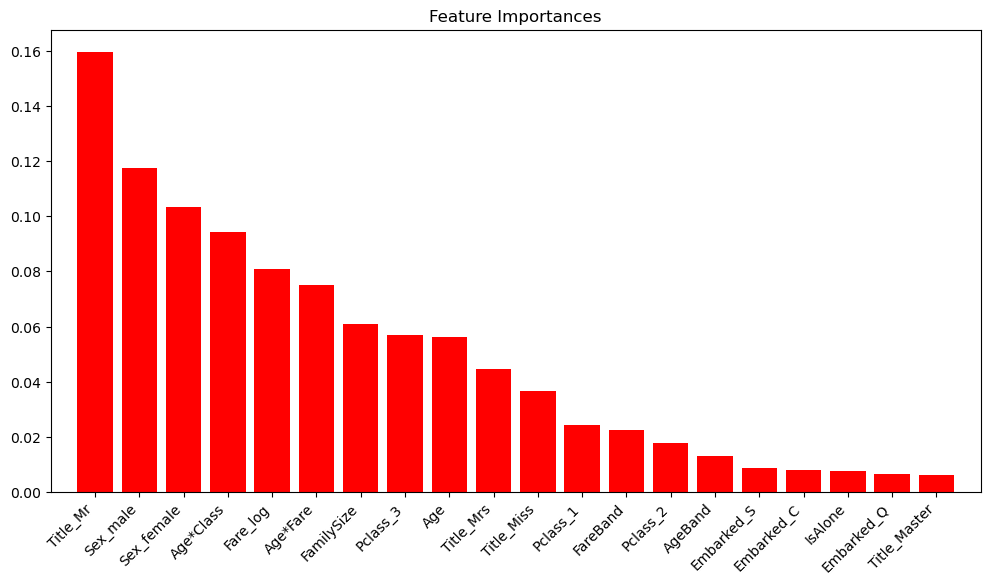

In [10]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices])
plt.xlim([-1, X_train.shape[1]])
plt.xticks(rotation=45, ha='right') 
plt.show()